# Code boxes Chapter 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pymc3 as pm

## Py code 2.1

In [2]:
ways = np.array([0, 3, 8, 9, 0])
print(ways/np.sum(ways))

[0.   0.15 0.4  0.45 0.  ]


## Py code 2.2

*Note:* The `binom` function has many different things that can be done with it after it is initialized. The first part initializes it with a given total sample size and probability (n, p). The second part `pmf` calculates the probability mass function for `k=6`.

In [3]:
result = stats.binom.pmf(k=6, n=9, p=0.5)
print(result)

0.16406250000000006


## Py code 2.3

In [4]:
# define the grid
p_grid = np.linspace(start=0, stop=1, num=20)

# define prior
prior = np.repeat(1, 20)

# compute likelihood at each value in grid
likelihood = result = stats.binom.pmf(k=6, n=9, p=p_grid)

# compute product of likelihood and prior -> unstandardized
unstd_posterior = likelihood * prior

# standardize the posterior so it sums to 1
posterior = unstd_posterior / np.sum(unstd_posterior)

## Py code 2.4

Text(0.5, 1.0, '20 points')

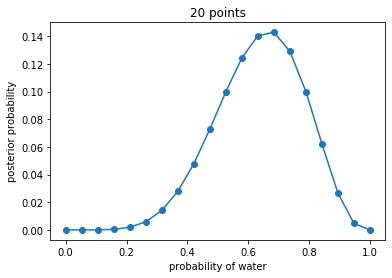

In [5]:
plt.plot(p_grid, posterior, '-o')
plt.xlabel('probability of water')
plt.ylabel('posterior probability')
plt.title('20 points')

## Py code 2.5

In [6]:
prior = np.ones(len(p_grid))
prior[np.where(p_grid < 0.5)] = 0

prior = np.exp(-5 * np.abs(p_grid - 0.5))

## Py code 2.6

Adopted from [PyMC3 resources](https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_02.ipynb)

In [7]:
# 9 tosses, three L (0), 6 water (1)
data = np.repeat((0,1), (3,6))
# runt he quadratic approximation
with pm.Model() as normal_approx:
    p = pm.Uniform ('p', 0, 1)   # uniform prior
    w = pm.Binomial('w', n=len(data), p=p, observed=data.sum())   # binomial likelihood
    # find local maximum a posteriori with this model
    pm.sample()
    mean_q = pm.find_MAP()
    # find the standard derivation
    std_q = ((1 / pm.find_hessian(mean_q, vars=[p])) **0.5)[0]
    
# print the poserior value (mean) and the curvature value (stdev)
print('The center of the Gaussian (mean) is at {0:.2f} and its standard '
      'deviation is {1:.2f}.'.format(mean_q['p'], std_q[0]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:00<00:00, 3213.28draws/s]
logp = -1.8075, ||grad|| = 1.5: 100%|██████████| 7/7 [00:00<00:00, 2798.87it/s]


The center of the Gaussian (mean) is at 0.67 and its standard deviation is 0.16.


In [8]:
# Also calculate the 89% percentile interval and print it out
norm = stats.norm(mean_q, std_q)
prob = 0.89
z = stats.norm.ppf([(1 - prob) / 2, (1 + prob) / 2])
perc = mean_q["p"] + std_q * z
perc

array([0.41553484, 0.91779849])

## Py code 2.7
Adopted from [PyMC3 resources](https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_02.ipynb)

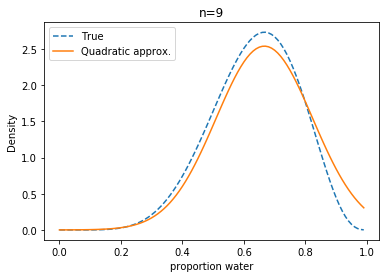

In [9]:
# Analytical calculation
W = 6
L = 3

# create the plot
x = np.arange(0, 1, 0.01)   # create an x array for beta function calc
plt.plot(x, stats.beta.pdf(x, W+1, L+1), '--', label='True')
plt.plot(x, stats.norm.pdf(x, mean_q["p"], std_q), label='Quadratic approx.')

# formatting of plot
plt.title('n=9')
plt.xlabel('proportion water')
plt.ylabel('Density')
plt.legend(loc='upper left')

## Py code 2.8

In [10]:
n_samples = 1000
p = np.empty(n_samples)

# assign the first value
p[0] = 0.5
W = 6
L = 3
ntot = W + L

# loop
for it in range(1, n_samples):
    # std * randn() + mean
    p_new = 0.1 * np.random.randn() + p[it - 1]
    if p_new < 0:
        p_new = np.abs(p_new)
    elif p_new > 1:
        p_new = 2 - p_new
    q0 = stats.binom.pmf(k=W, n=ntot, p=p[it - 1])
    q1 = stats.binom.pmf(k=W, n=ntot, p=p_new)
    # draw a random number from 0 to 1
    if np.random.rand() < q1 / q0:
        p[it] = p_new
    else:
        p[it] = p[it - 1]

## Py code 2.9

*Note*: Instead of the `dens` function that is used in the book and which is part of the `rethinking` package, a `kdeplot` from the seaborns package is used here, which plots a univariate kernel density estimate. The standard configuration is smoother than the plot that is created by the `dens` function in the `rethinking` package. We can make this plot "rougher" by selecting a lower bandwidth, e.g., `bw=0.1` as selected below.

Text(0, 0.5, 'Density')

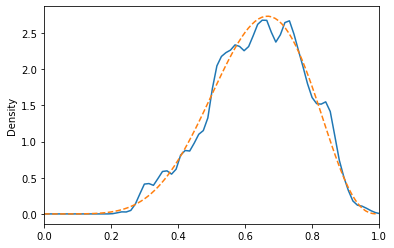

In [11]:
# density plot using seaborn's distplot routine
sns.kdeplot(p, bw=0.1)
# plot the "true" distributio with scipy.stats beta function
x = np.arange(0, 1, 0.01)   # create an x array for beta function calc
plt.plot(x, stats.beta.pdf(x, W+1, L+1), '--')
plt.xlim(0, 1)
plt.ylabel('Density')